# Konkurs | 8 edycja kursu "Praktyczne uczenie maszynowe"

### Kaggle 
Konkurs będzie dostępny na Kaggle - link do [konkursu](https://bit.ly/3mFk2A0).

In [6]:
import pandas as pd
import numpy as np
np.random.seed(0)

import re
import sys

# model
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import xgboost as xgb
import catboost as ctb

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import scikitplot as skplt
from scikitplot.estimators import plot_learning_curve


# metrics
from sklearn.metrics import mean_absolute_error as mae

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
### read data
train = pd.read_hdf('../input/property.train.h5')
test = pd.read_hdf('../input/property.test.h5') # test data without prices

In [8]:
#train.info()
#train.describe()
#train.sample(10)

In [9]:
df_all = pd.concat([train, test], axis=0)
print("train & test: ", train.shape, test.shape)

### Features engineering

train & test:  (45694, 35) (22667, 35)


In [10]:
### Extract + factorize geo_block - VA starter
print("Extract + factorize geo_block")    

def extract_geoblock(vals):
    vals = vals[: int(len(vals) / 2)]
    return {"geo_block_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

df_geo_block = df_all["geo_block"].map(extract_geoblock).apply(pd.Series)
df_all = pd.concat([df_all, df_geo_block], axis=1)

feats_geo_block = [ x for x in df_geo_block.columns]

for f in feats_geo_block:
    df_all["{}_cat".format(f)] = df_all[f].factorize()[0]

Extract + factorize geo_block


In [11]:
### Extract + factorize breadcrumbs - by JM
print("Factorize breadcrumbs")    
address_street_codes = ['ул.','проезд.','пр-кт.','б-р.','пер.','аллея.','пл.']
address_city_codes = ['г.','д.','с.']
address_metro_station_codes = ['м.']
address_rail_station_codes = ['МЦК ']
address_park_codes = ['Парк']
address_district_2_codes = ['п.','рп.']

address_codes = address_street_codes + \
                address_city_codes + \
                address_metro_station_codes + \
                address_rail_station_codes + \
                address_park_codes + \
                address_district_2_codes
#print(address_codes)
                
def get_district(row, address_codes, district_level):
    ret_str = ''
    
    if len(row) <= 1:
        return 'nan'
    
    ## District 1
    if (district_level == 1) and (len(row) >= 2):
        cc = row[1].lower()
        is_address_code = 0
        
        for ac in address_codes:
            if ac.lower() in cc.lower():
                is_address_code += 1
        
        if is_address_code == 0:
            ret_str = cc

    ## District 2
    if (district_level == 2) and (len(row) >= 2):

        for cc in row[1:]:
            is_address_code = 0
            if 'п.' in cc.lower():
                ret_str = ret_str + cc + ' - '

        if ret_str == '' :
            ret_str = 'NaN'
        else:
            ret_str = ret_str[:len(ret_str)-3] # remove ' - ' in the end of string
        
    ## District 3
    if (district_level == 3) and (len(row) >= 3):
    
        for cc in row[2:]:
            is_address_code = 0
            for ac in address_codes:
                if ac.lower() in cc.lower():
                    is_address_code += 1
            if is_address_code == 0:
                ret_str = cc

    if ret_str == '' :
        ret_str = 'NaN'
    
    return str(ret_str).lower().strip()

def get_value(row,search_string_arr):
    ret_str = 'NaN'
    for cc in row:
        for st in search_string_arr:
            if st.lower() in cc.lower():
                ret_str = cc
    return str(ret_str).lower().strip()   

df_all['breadcrumbs_city'] = df_all['breadcrumbs'].map(lambda x: x[0])
df_all['breadcrumbs_district_1'] = df_all['breadcrumbs'].map(lambda x: get_district(x,address_codes,1))
df_all['breadcrumbs_district_2'] = df_all['breadcrumbs'].map(lambda x: get_district(x,address_codes,2))
df_all['breadcrumbs_district_3'] = df_all['breadcrumbs'].map(lambda x: get_district(x,address_codes,3))
df_all['breadcrumbs_city_2'] = df_all['breadcrumbs'].map(lambda x: get_value(x,address_city_codes))
df_all['breadcrumbs_street'] = df_all['breadcrumbs'].map(lambda x: get_value(x,address_street_codes))
df_all['breadcrumbs_metro_station'] = df_all['breadcrumbs'].map(lambda x: get_value(x,address_metro_station_codes))
df_all['breadcrumbs_rail_station'] = df_all['breadcrumbs'].map(lambda x: get_value(x,address_rail_station_codes))
df_all['breadcrumbs_park'] = df_all['breadcrumbs'].map(lambda x: get_value(x,address_park_codes))
df_all['is_park_cat'] = df_all['breadcrumbs_park'].map(lambda x: 1 if x != 'nan' else 0)

factorize_breadcrumbs_feats = [f for f in df_all.columns if "breadcrumbs_" in f]
#print("factorize_breadcrumbs_feats: ", factorize_breadcrumbs_feats)
for ff in factorize_breadcrumbs_feats:
    df_all["{}_cat".format(ff)] = df_all[ff].factorize()[0]

Factorize breadcrumbs


In [13]:
### Extract + factorize breadcrumbs - by VA idea
print("Extract + factorize breadcrumbs")    

def extract_breadcrumbs(vals):
    vals = vals[: int(len(vals))]
    return {"breadcrumbs_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

df_breadcrumbs = df_all["breadcrumbs"].map(extract_breadcrumbs).apply(pd.Series)
df_all = pd.concat([df_all, df_breadcrumbs], axis=1)

feats_breadcrumbs = [ x for x in df_breadcrumbs.columns]

for fb in feats_breadcrumbs:
    df_all["{}_2_cat".format(fb)] = df_all[fb].factorize()[0]


Extract + factorize breadcrumbs


In [14]:
### Factorize date
print("Factorize date")    

def extract_date(vals):
    vals = vals[: int(len(vals))]
    return {"date_{}".format(idx):val.strip().lower() for idx, val in enumerate(vals)}

df_date = df_all["date"].map(extract_date).apply(pd.Series)
df_date['date_1_cat'] = df_date['date_1'].map(lambda x: int(x))

df_all = pd.concat([df_all, df_date], axis=1)

feats_date_cat = ['date_0','date_2','date_3']
for fd in feats_date_cat:
    df_all["{}_cat".format(fd)] = df_all[fd].factorize()[0]

Factorize date


In [15]:
### Factorize *: columns by VA - VA starter
print("Factorize *: columns")
factorize_other_feats = [f for f in df_all.columns if ":" in f]
for feat in factorize_other_feats:
    df_all["{}_cat".format(feat)] = df_all[feat].factorize()[0]

Factorize *: columns


In [16]:
### Owner
df_all['owner_str'] = df_all['owner'].map(lambda x: str(x[0]) if (len(x)>0) else 'nan')
df_all["owner_cat"] = df_all['owner_str'].factorize()[0]

In [17]:
### Split for train and test 
df_train, df_test = df_all[ False == df_all["price"].isnull() ], df_all[ df_all["price"].isnull() ]

In [18]:
### VA starter + hyperopt
feats = [x for x in df_all.columns if "_cat" in x]
#print("feats: ", feats)

X_train, X_test = df_train[feats].values, df_test[feats].values
y_train = df_train["price"].values

y_log_train = np.log(y_train)

print("train model")
#model = xgb.XGBRegressor(n_estimators=70, learning_rate=0.2, max_depth=10, random_state=0)
model = xgb.XGBRegressor(
    n_estimators=50, #200
    colsample_bytree=0.8566713008117716,  
    learning_rate=0.14342660714953284, 
    max_depth=20, 
    min_child_weight=6.0,
    random_state=0,
    reg_alpha=1.9166748702047074, 
    reg_lambda=0.8627457435047747, 
    subsample=0.9982487838808752)
xgb_rmodel = model.fit(X_train, y_log_train)

print("predict")
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)
y_pred[y_pred<=0] = y_pred.min()

train model
predict


In [19]:
### save file
print("save file")
test['price'] = y_pred
test[ ['id', 'price'] ].to_csv('../output/xgboost_12.csv', index=False)

save file


Feature Importance


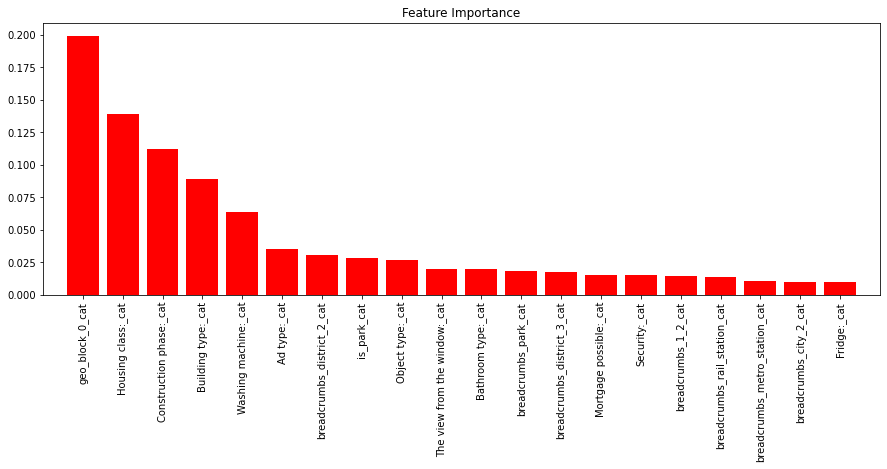

In [20]:
print("Feature Importance")
title='Feature Importance'
skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    

In [ ]:
#print("xgbfir")
#import xgbfir
#xgb_rmodel = xgb.XGBRegressor().fit(X_train, y_log_train)
#xgbfir.saveXgbFI(xgb_rmodel, feature_names=feats, OutputXlsxFile='../output/xgbfir_fi_2.xlsx')

In [21]:
### train_test_split

# wydzielam lokalny zbiór treningowy i testowy
feats = [x for x in df_train.columns if "_cat" in x]

X_train, X_test, y_train, y_test = train_test_split(df_train[feats], df_train[['price']], test_size=0.2, random_state=0)
y_log_train = np.log(y_train)

print("train model")
#model = xgb.XGBRegressor(n_estimators=70, learning_rate=0.2, max_depth=10, random_state=0)
#model = ctb.CatBoostRegressor(n_estimators=70, depth=10, random_state=0, verbose=False)
model = xgb.XGBRegressor(
    n_estimators=50, 
    colsample_bytree=0.8566713008117716,  
    learning_rate=0.14342660714953284, 
    max_depth=20, 
    min_child_weight=6.0,
    random_state=0,
    reg_alpha=1.9166748702047074, 
    reg_lambda=0.8627457435047747, 
    subsample=0.9982487838808752)

model.fit(X_train, y_log_train)

print("predict")
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)
y_pred[y_pred<=0] = y_train.min()

print("MAE: ",mae(y_test,y_pred)) 
# 5.132231612597657 xgb
# 5.153294450526949 xgb + hyperopt
# 5.374401953596552 ctb


train model
predict
MAE:  5.153294450526949


In [22]:
import xgbfir
xgb_rmodel = xgb.XGBRegressor().fit(X_train, y_log_train)
xgbfir.saveXgbFI(xgb_rmodel, feature_names=feats, OutputXlsxFile='../output/xgbfir_fi.xlsx')
aa1 = pd.read_excel('../output/xgbfir_fi.xlsx', 'Interaction Depth 0')
aa2 = pd.read_excel('../output/xgbfir_fi.xlsx', 'Interaction Depth 1')
aa3 = pd.read_excel('../output/xgbfir_fi.xlsx', 'Interaction Depth 2')

In [ ]:
### HYPEROPT
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 20,
        'objective': 'reg:squarederror'
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mae(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 100, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.8, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.3),
    'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
}
#('XGBoost', xgb.XGBRegressor(n_estimators=70, learning_rate=0.2, max_depth=10, random_state=0)),


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

#100%|██████████| 30/30 [01:09<00:00,  2.32s/trial, best loss: 5.099937308653067]
# The best params:  {'x_colsample_bytree': 0.8566713008117716, 'x_learning_rate': 0.14342660714953284, 
# 'x_max_depth': 20.0, 'x_min_child_weight': 6.0, 'x_random_state': 1500.0, 'x_reg_alpha': 1.9166748702047074, 
# 'x_reg_lambda': 0.8627457435047747, 'x_subsample': 0.9982487838808752}

In [ ]:
#trials.best_trial

In [24]:
def get_feats(df):
    feats = df.select_dtypes(include=[int, float]).columns 
    return feats[ (feats != 'price') & (feats != 'price_log') ].values

def get_X(df):
    return df[ get_feats(df) ].values

def get_y(df, target_var='price'):
    return df[target_var].values

def run_cv(model, X, y, Xt, folds=4, target_log=False,cv_type=KFold, success_metric=mae, with_test=False):
    cv = cv_type(n_splits=folds, shuffle=True, random_state=0)
    
    scores = []
    for train_idx, test_idx in cv.split(X):      # KFold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)

        if with_test:
            ff = get_feats(Xt)
            X_test = Xt[ff].values

        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
            if (with_test == False) and (len(y_pred) > 0):
                y_pred[y_pred <= 0] = y_pred.min() #czasem może być wartość ujemna
                
        if with_test == False:
            score = success_metric(y_test, y_pred)
            scores.append( score )
        else:
            scores.append([-1,-1])
    
    return np.mean(scores), np.std(scores), y_pred


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            
        y_pred[ y_pred<=0 ] = y_pred.min()
        
        return mae(y, y_pred)


    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def get_models():
    return [
#        ('XGBoost', xgb.XGBRegressor(n_estimators=70, learning_rate=0.2, max_depth=10, random_state=0)),
        ('XGBoost', xgb.XGBRegressor(
                        n_estimators=50, 
                        colsample_bytree=0.8566713008117716,  
                        learning_rate=0.14342660714953284, 
                        max_depth=20, 
                        min_child_weight=6.0,
                        random_state=0,
                        reg_alpha=1.9166748702047074, 
                        reg_lambda=0.8627457435047747, 
                        subsample=0.9982487838808752)
        ),
#        ('CatBoost', ctb.CatBoostRegressor(n_estimators=70, max_depth=10, random_state=0)),
    ]
def run(train, df_test, plot_lc=False, folds=3, ylim=(0, 2), target_log=False, with_test=False):
    X, y  = get_X(train), get_y(train)

    for model_name, model in get_models():
        score_mean, score_std, y_pred = run_cv(model, X, y, df_test, folds=folds, target_log=target_log, with_test=with_test)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        if model_name != 'CatBoost':
            sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania
            
        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
        plt.show()
        
    return y_pred



In [27]:
#df_train.columns
y_pred = run(df_train, df_test, plot_lc=False, target_log=True, with_test=True)
# [XGBRegressor]: 5.163914615929549 +/-0.17341771527896557 - price_log KFOld

[XGBoost]: -1.0 +/-0.0


In [29]:
### Zapis do pliku
print("# save file")
test['price'] = y_pred
test[ ['id', 'price'] ].to_csv('../output/jm_xgboost_v7.csv', index=False)

# save file


In [12]:
def check_missing(df):
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
#check_missing(df_train)

In [30]:
#with pd.option_context('display.max_colwidth', 100):
#    display(train[['breadcrumbs']])